## **Open Rituals**

Import needed package and define paths and useful functions

In [28]:
#%% open rituals ##############################################################
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from pyproj import Transformer
import matplotlib as mpl
import geopandas as gpd
from scipy import stats
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import spotpy
import os

### replace this main directory with your own
Path_Main = r'C:\Users\lli55\Desktop\Lingbo Li PhD\DOC project\Model_with_SoilGrid'
Path_Plot = os.path.join(Path_Main, 'plot')
Path_Output = os.path.join(Path_Main, 'output')
Path_Shape = os.path.join(Path_Main, 'shape')
Path_Input = os.path.join(Path_Main, 'input')

def get_density(x:np.ndarray, y:np.ndarray):
    """Get kernal density estimate for each (x, y) point."""
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    density = kernel(values)
    return density

def nrmse(sim, obs):
    return spotpy.objectivefunctions.rrmse(obs, sim)

def mase(preds, Dtrain): 
    y = Dtrain.get_label()
    y_1 = np.array([1e-6*i for i in y])
    preds_1 = np.array([1e-6*i for i in preds])
    mae = np.mean(np.abs(y_1 - preds_1)) 
    gm = np.exp(np.mean(np.log(y_1))) 
    #rmse = spotpy.objectivefunctions.rmse(y_1, preds_1)
    mase = mae / gm
    return 'mase', mase	

def mase_plot(sim, obs): 
    y = np.array([i for i in obs])
    pred = np.array([i for i in sim])
    mae = np.mean(np.abs(y - pred)) 
    gm = np.exp(np.mean(np.log(y))) 
    return mae / gm

## **$P_r$ distribution map (Figure 1)**

In [ ]:
# Define paths
Path_Main_Old = r'C:\Users\lli55\Desktop\Lingbo Li PhD\DOC project'
path_r = os.path.join(Path_Main_Old, 'USA_Rivers_and_Streams')

# Load train and evaluation site locations
train_loc = pd.read_csv(os.path.join(Path_Main_Old, '2595_train_sites.csv'), usecols=['lat', 'lon', 'comid'])
eval_loc = pd.read_csv(os.path.join(Path_Main_Old, '3210_eval_sites.csv'), usecols=['lat', 'lon', 'comid'])

# Load train and evaluation precipitation data
train_pr = pd.read_csv(os.path.join(Path_Input, 'train_set.txt'), sep='\t', usecols=['COMID', 'pr_soilgrid'])
eval_pr = pd.read_csv(os.path.join(Path_Input, 'eval_set.txt'), sep='\t', usecols=['COMID', 'pr_soilgrid'])

# Merge train and evaluation sets with location data
train_set = train_pr.merge(train_loc, left_on='COMID', right_on='comid').dropna().reset_index(drop=True)
eval_set = eval_pr.merge(eval_loc, left_on='COMID', right_on='comid').dropna().reset_index(drop=True)

# Function to cap outliers at the 5th and 95th percentiles
def cap_outliers(df, column):
    """Cap values in the specified column to the 5th and 95th percentiles."""
    lower_bound = np.percentile(df[column], 5)
    upper_bound = np.percentile(df[column], 95)
    df[column] = np.clip(df[column], lower_bound, upper_bound)

# Cap outliers for train and eval sets
cap_outliers(train_set, 'pr_soilgrid')
cap_outliers(eval_set, 'pr_soilgrid')

# Load US boundary shapefile and extract the CONUS boundary
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
conus_geo = world.loc[world['name'] == "United States of America", 'geometry'].iloc[0][0]
conus = gpd.GeoDataFrame(geometry=[conus_geo], crs=world.crs)

# Load and clip US rivers shapefile using CONUS boundary
river = gpd.read_file(os.path.join(path_r, 'ne_10m_rivers_lake_centerlines.shp'))
river_clipped = gpd.clip(river, conus)

# Convert CRS of shapefiles to EPSG:5070 (Albers Equal Area)
conus = conus.to_crs("EPSG:5070")
river_clipped = river_clipped.to_crs("EPSG:5070")

# Convert train and eval site locations to EPSG:5070
transformer = Transformer.from_crs("EPSG:4326", "EPSG:5070", always_xy=True)

train_set['lon_proj'], train_set['lat_proj'] = transformer.transform(train_set['lon'].values, train_set['lat'].values)
eval_set['lon_proj'], eval_set['lat_proj'] = transformer.transform(eval_set['lon'].values, eval_set['lat'].values)

In [ ]:
# Set global plot parameters
plt.rcParams['font.size'] = 10

# Create figure and grid specification
fig = plt.figure(figsize=(6, 7), constrained_layout=True)
spec = fig.add_gridspec(2, 1)

# Plot for train set
ax0 = fig.add_subplot(spec[0, 0])
ax0.set_title('a) $P_r$ of independent catchments', loc='left')
im_1 = ax0.scatter(
    train_set['lon_proj'], train_set['lat_proj'], 
    marker='o', 
    c=train_set['pr_soilgrid'], 
    s=5, 
    edgecolors='k', 
    linewidths=0.2, 
    cmap='rainbow'
)
river_clipped.plot(ax=ax0, color='grey', linewidth=0.5, label='riverline')
conus.plot(ax=ax0, facecolor='none', edgecolor='k', linewidth=0.6, label='CONUS boundary')
ax_cbar_1 = fig.colorbar(im_1, ax=ax0, shrink=0.6, pad=0.01, format='%.1e', extend='both')
ax_cbar_1.set_label('$P_r$ ($m^3$ soil / $m^3$ water)')
ax0.set_xlim([-2.5e6, 2.5e6])
ax0.set_ylim([0.2e6, 3.3e6])
ax0.axis('off')

# Plot for evaluation set
ax1 = fig.add_subplot(spec[1, 0])
ax1.set_title('b) $P_r$ of evaluation catchments', loc='left')
im_2 = ax1.scatter(
    eval_set['lon_proj'], eval_set['lat_proj'], 
    marker='o', 
    c=eval_set['pr_soilgrid'], 
    s=5, 
    edgecolors='k', 
    linewidths=0.2,  
    cmap='rainbow'
)
river_clipped.plot(ax=ax1, color='grey', linewidth=0.5, label='riverline')
conus.plot(ax=ax1, facecolor='none', edgecolor='k', linewidth=0.6, label='CONUS boundary')
ax_cbar_2 = fig.colorbar(im_2, ax=ax1, shrink=0.6, pad=0.01, format='%.1e', extend='both')
ax_cbar_2.set_label('$P_r$ ($m^3$ soil / $m^3$ water)')
ax1.set_xlim([-2.5e6, 2.5e6])
ax1.set_ylim([0.2e6, 3.3e6])
ax1.axis('off')

# Save the figure
output_path = os.path.join(Path_Plot, 'sites_distribution.png')
fig.savefig(output_path, dpi=600, bbox_inches='tight')

## **SHAP feature importance (Figure 3)**

In [ ]:
important_12 = pd.read_csv(os.path.join(Path_Output, 'importance_12.csv'))
important_13 = pd.read_csv(os.path.join(Path_Output, 'importance_13.csv'))
important = important_13.merge(important_12, on ='predictors', how = 'left')
important_sorted = important.sort_values(by = 'SHAP_mean_12', ascending=False).reset_index(drop = True)
# Rename columns for better readability
predictors_mapping = {
    'TOT_B': 'temp_related', 
    'TOT_CONTACT': 'CONTACT', 
    'TOT_A': 'hydro_related', 
    'TOT_I': 'elev_related', 
    'TOT_NLCD01_90': 'NLCD01_90', 
    'TOT_HGBD': 'HGBD', 
    'TOT_CNPY11_BUFF100': 'CNPY11_BUFF100', 
    'TOT_HGB': 'HGB', 
    'TOT_CLAYAVE': 'CLAYAVE', 
    'TOT_NLCD01_42': 'NLCD01_42', 
    'TOT_E': 'soil_texture_related', 
    'TOT_BFI': 'BFI', 
    'TOT_NLCD01_95': 'NLCD01_95'
}

# Replace values in the 'predictors' column
important_sorted['predictors'] = important_sorted['predictors'].replace(predictors_mapping)

In [ ]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)
fig.patch.set_facecolor('white')
plt.rcParams['font.size'] = 10
spec = fig.add_gridspec(1, 1)

ax = fig.add_subplot(spec[0, 0])
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)
bar_width = 0.45
# Define positions
index = np.arange(len(important_sorted))

# Plot bars for shap_15 and shap_12
bars1 = ax.bar(index, important_sorted['SHAP_mean_13'], bar_width, label='13 predictors' ,zorder=2)
bars2 = ax.bar(index + bar_width, important_sorted['SHAP_mean_12'], bar_width, label='12 predictors', color='orange' ,zorder=2)

# Add labels, title, and legend
ax.spines[['top','right']].set_visible(False)
ax.spines['bottom'].set_linewidth(1.1)
ax.spines['left'].set_linewidth(1.1)
ax.set_ylabel('Mean absolute SHAP value \n($m^3 \ soil/ m^3 \ water$)')
ax.set_xticks(index + bar_width/2)
ax.set_xticklabels(important_sorted['predictors'], rotation=90, ha='center')
ax.legend(loc=7, bbox_to_anchor=(0.98, 0.85), ncol=1, borderaxespad=0, frameon=True, fontsize=8)
ax.set_ylim((0,6.5e-5))
ax.set_xlim((-0.5,12.5))
fig.savefig(os.path.join(Path_Plot,'SHAP_values_predictors.png'), dpi = 300)

## **Final model performance on $P_r$(Figure 4)**

In [ ]:
# Load performance data
performance_12 = pd.read_csv(os.path.join(Path_Output, 'performance_12.csv'))

# Extract Y_train and Y_test after dropping NaNs
Y_train = performance_12['Y_train'].dropna()
Y_test = performance_12['Y_test'].dropna()
predict_train_12 = performance_12['Predict_train_12'].dropna()
predict_test_12 = performance_12['Predict_test_12'].dropna()

# Create x-axis range
x = np.arange(0, 1e-2, 1e-5)

In [ ]:
# Initialize the figure and layout
fig = plt.figure(figsize=(8, 5), constrained_layout=True)
spec = fig.add_gridspec(1, 2)

# Plot for Training Data
ax10 = fig.add_subplot(spec[0, 0])
ax10.grid(which="both", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax10.grid(which="both", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)
ax10.spines[['top', 'right']].set_visible(False)

d10 = get_density(np.log10(Y_train), np.log10(predict_train_12))
sca10 = ax10.scatter(Y_train, predict_train_12, s=10, edgecolor='k', linewidth=0, c=d10, cmap='RdYlBu', zorder=2, alpha=0.75)
ax10.plot(x, x, color='k', linewidth=1)
ax10.set_ylabel('Simulated $P_r$  ($m^3$ soil / $m^3$ water)')
ax10.set_xlabel('Estimated $P_r$  ($m^3$ soil / $m^3$ water)')
ax10.set_xscale('log')
ax10.set_yscale('log')
ax10.set_xlim((1e-5, 1e-2))
ax10.set_ylim((1e-5, 1e-2))
ax10.tick_params('both', length=10, width=1, which='major')
ax10.tick_params('both', length=5, width=0.5, which='minor')
ax10.set_title('a) Training', loc='left')

ax10.text(1.2e-3, 1.5e-5, 
          f'MASE: {mase_plot(predict_train_12, Y_train):.2f}\n' + 
          f'NRMSE: {nrmse(predict_train_12, Y_train):.2f}\n' + 
          f'$R^2$: {np.corrcoef(Y_train, predict_train_12)[0, 1]:.2f}', 
          style='italic')

cbar10 = plt.colorbar(sca10, location='bottom')
cbar10.update_ticks()
cbar10.set_label('Density of points')

# Plot for Testing Data
ax11 = fig.add_subplot(spec[0, 1])
ax11.grid(which="both", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax11.grid(which="both", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)
ax11.spines[['top', 'right']].set_visible(False)

d11 = get_density(np.log10(Y_test), np.log10(predict_test_12))
sca11 = ax11.scatter(Y_test, predict_test_12, s=10, edgecolor='k', linewidth=0, c=d11, cmap='RdYlBu', zorder=2)
ax11.plot(x, x, color='k', linewidth=1)
ax11.set_xlabel('Estimated $P_r$ ($m^3$ soil / $m^3$ water)')
ax11.set_xscale('log')
ax11.set_yscale('log')
ax11.set_xlim((1e-5, 1e-2))
ax11.set_ylim((1e-5, 1e-2))
ax11.tick_params('x', length=8, width=1, which='major')
ax11.tick_params('x', length=4, width=0.5, which='minor')
ax11.tick_params('y', length=0, width=0, which='minor')
ax11.set_yticks([])
ax11.set_title('b) Testing', loc='left')

ax11.text(1.2e-3, 1.5e-5, 
          f'MASE: {mase_plot(predict_test_12, Y_test):.2f}\n' + 
          f'NRMSE: {nrmse(predict_test_12, Y_test):.2f}\n' + 
          f'$R^2$: {np.corrcoef(Y_test, predict_test_12)[0, 1]:.2f}', 
          style='italic')

cbar11 = plt.colorbar(sca11, location='bottom')
cbar11.set_label('Density of points')

# Set font size globally
plt.rcParams['font.size'] = 10

# Save the figure
fig.savefig(os.path.join(Path_Plot, 'performance_pr.png'), dpi=300)


## **Correlation heatmap (Figure 5)**

In [ ]:
# Selected predictors
selected_feature = [
    'pr_soilgrid', 'TOT_A', 'TOT_NLCD01_90', 'TOT_CONTACT', 'TOT_B', 
    'TOT_I', 'TOT_BFI', 'TOT_E', 'TOT_CLAYAVE', 'TOT_HGB', 
    'TOT_NLCD01_42', 'TOT_CNPY11_BUFF100', 'TOT_HGBD'
]

# Load dataset
data = pd.read_csv(os.path.join(Path_Input, 'train_set.txt'), delimiter='\t')[selected_feature]

# Rename columns for better readability
data.rename(columns={
    'pr_soilgrid': 'pr', 
    'TOT_A': 'hydro_related', 
    'TOT_NLCD01_90': 'NLCD01_90',
    'TOT_CONTACT': 'CONTACT', 
    'TOT_B': 'temp_related', 
    'TOT_I': 'elev_related', 
    'TOT_BFI': 'BFI', 
    'TOT_E': 'soil_texture_related', 
    'TOT_CLAYAVE': 'CLAYAVE', 
    'TOT_HGB': 'HGB', 
    'TOT_NLCD01_42': 'NLCD01_42', 
    'TOT_CNPY11_BUFF100': 'CNPY11_BUFF100', 
    'TOT_HGBD': 'HGBD'
}, inplace=True)

In [ ]:
plt.figure(figsize=(8, 6.4))
# Define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(data.corr(), dtype=bool))

# Set theme and color palette
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Plot heatmap
heatmap = sns.heatmap(
    data.corr(), 
    mask=mask, 
    vmin=-0.8, 
    vmax=0.8, 
    annot=True, 
    cmap=cmap, 
    center=0, 
    square=True, 
    fmt='.2f', 
    cbar_kws={'label': 'Correlation coefficient'}, 
    annot_kws={"size": 10}
)

# Save heatmap plot
plt.savefig(os.path.join(Path_Plot, 'Covariance_heatmap.png'), dpi=400, bbox_inches='tight')

## **Spatial plots of Pr and DOC (Figure 6 & 9)**

In [ ]:
# Load geospatial and predicted Pr over 2.6 million local catchment
data = gpd.read_file(os.path.join(Path_Shape, 'SOC.gpkg'), driver='GPKG')
pr_soilgrid = pd.read_csv(os.path.join(Path_Output, 'pr_at_2_6m.txt'), sep='\t').rename(columns={'pr': 'pr_soilgrid'})
Path_Output_old = r'C:\Users\lli55\Desktop\Lingbo Li PhD\DOC project\Data'
pr_hwsd = pd.read_csv(os.path.join(Path_Output_old, 'pr_at_2_6m_mase.txt'), sep='\t').rename(columns={'pr': 'pr_hwsd'})

# Merge precipitation data with geospatial data
data = data.merge(pr_hwsd, on='COMID', how='left')
data = data.merge(pr_soilgrid, on='COMID', how='left')

# Calculate DOC-related columns
data['doc_hwsd'] = data['soc_hwsd'] * data['pr_hwsd']
data['doc_soilgrid'] = data['soc_soilgrid'] * data['pr_soilgrid']

# update the SOC.gpkg file
data.to_file(os.path.join(Path_Shape, 'SOC.gpkg'))

### **Spatial Pr map**

In [ ]:
data = gpd.read_file(os.path.join(Path_Shape, 'SOC.gpkg'), driver='GPKG')
data = data.to_crs("EPSG:5070")
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
conus_geo = world[world.name == "United States of America"].geometry.iloc[0][0]
conus = gpd.GeoDataFrame(geometry=[conus_geo], crs=world.crs).to_crs("EPSG:5070")
quan_05, quan_95 = np.percentile(data['pr_soilgrid'], [5, 95])
data['pr_soilgrid'].values[data['pr_soilgrid'].values > quan_95] = quan_95
data['pr_soilgrid'].values[data['pr_soilgrid'].values < quan_05] = quan_05

In [ ]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 5), constrained_layout=True)

# Normalize color scale for 'pr_soilgrid'
norm = colors.Normalize(vmin=quan_05, vmax=quan_95)
cbar = plt.cm.ScalarMappable(norm=norm, cmap='rainbow')

# Plot CONUS boundary and 'pr_soilgrid' data
conus.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=1)
data.plot(ax=ax, column='pr_soilgrid', cmap='rainbow', linewidth=0.5, legend=False)

# Add color bar
ax_cbar = fig.colorbar(cbar, ax=ax, shrink=0.5, pad=0.01, extend='both', format='%0.0e')
ax_cbar.set_label('$P_r$ ($m^3$ soil / $m^3$ water)')

# Remove axis
ax.axis('off')

# Save the plot
output_path = os.path.join(Path_Plot, 'conus_pr_map.png')
fig.savefig(output_path, dpi=800, bbox_inches='tight')

### **Spatial DOC map**

In [ ]:
Y = data.dropna(subset = 'doc_soilgrid').copy()
## Duo to missing values of SOC, only 2434427 catchment left for DOC calculation
Y['doc_soilgrid'].values[Y['doc_soilgrid'].values > np.percentile(Y['doc_soilgrid'], 95)] = np.percentile(Y['doc_soilgrid'], 95)

# Plot the map of DOC leaching fluxes
fig, ax = plt.subplots(figsize=(7, 5), constrained_layout=True)
plt.rcParams['font.size'] = 10

# Normalize color scale for 'doc' values
norm = colors.Normalize(vmin=0, vmax=12)
cbar = plt.cm.ScalarMappable(norm=norm, cmap='rainbow')

# Plot CONUS boundary and 'doc' column data
conus.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=1)
Y.plot(ax=ax, column='doc_soilgrid', cmap='rainbow', linewidth=0.5, legend=False)

# Add color bar
ax_cbar = fig.colorbar(cbar, ax=ax, shrink=0.7, pad=0.01, extend='max')
ax_cbar.set_label('$C_{DOC\_runoff}$ ($mg/L$)')

# Remove axis
ax.axis('off')

# Save the plot
output_path_doc = os.path.join(Path_Plot, 'conus_doc_map.png')
fig.savefig(output_path_doc, dpi=800, bbox_inches='tight')

## **DOC validation at evaluation catchments (Figure 7)**

In [ ]:
## those two data are in the same row order
eval = pd.read_csv(os.path.join(Path_Output, 'eval_validation.txt'), sep = '\t')
## 2 catchments can does not have a valid derived DOC duo to missing in SOC data
eval = eval.dropna(subset = 'derived_doc').reset_index(drop = True)
obs = eval['ave_doc']
sim = eval['derived_doc']
d = get_density(np.log10(obs), np.log10(sim))
x = np.arange(0, 200, 1)

In [ ]:
fig = plt.figure(figsize=(5.5,5), constrained_layout=True)
spec = fig.add_gridspec(1, 1)
ax01 = fig.add_subplot(spec[0, 0])
ax01.grid(which="both", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax01.grid(which="both", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)
ax01.spines[['top','right']].set_visible(False)

sca01 = ax01.scatter(obs, sim, s = 10, ec = 'k', linewidth = 0, c = d, cmap = 'RdYlBu', zorder=2, alpha = 0.75)
ax01.plot(x,x, c = 'k', linewidth = 1)
ax01.set_yscale('log')
ax01.set_xscale('log')
ax01.tick_params('both', length=8, width=1, which='major')
ax01.tick_params('both', length=4, width=0.5, which='minor')
ax01.set_xlim((2e-1,2e2))
ax01.set_ylim((2e-1,2e2))
ax01.set_ylabel('Derived $DOC$ concentration (mg/L)' )
ax01.set_xlabel('Observed $DOC$ concentration (mg/L)')
ax01.text(24, 0.3,
          'MASE: ' + str("{:.2f}".format(mase_plot(sim, obs))) + 
          '\nNRMSE: ' + str("{:.2f}".format(nrmse(sim, obs))) +
          '\n$R^2$: ' + str("{:.2f}".format(np.corrcoef(obs, sim)[0,1])),
          style='italic')
# cbar = plt.colorbar(sca)
# cbar.locator = MultipleLocator(base=0.5)
# cbar.update_ticks()
cbar01 = plt.colorbar(sca01)
cbar01.set_label('Density of points')

plt.rcParams['font.size'] = 10
fig.savefig(os.path.join(Path_Plot,'DOC_3208_eval.png'), dpi = 300, bbox_inches = 'tight')

## **Model sensitivity plot (Figure 8)**

In [ ]:
selected_feature = ['TOT_A', 'TOT_NLCD01_90', 'TOT_CONTACT', 'TOT_B', 'TOT_I', 'TOT_BFI', 'TOT_E', 'TOT_CLAYAVE', 'TOT_HGB', 'TOT_NLCD01_42', 'TOT_CNPY11_BUFF100', 'TOT_HGBD']

best_param = {'lambda': 0.8497244598535406, 'alpha': 0.0219789569818175, 'gamma': 0.09045149625652132, 'eta': 0.11455856438869257, 'min_child_weight': 0.31227906516564546, 'colsample_bytree': 0.5004486262490111, 'subsample': 0.9729520009435804, 'max_depth': 8, 'booster': 'gbtree', 'disable_default_eval_metric': 1}

n_estimators = 20
early_stop = int(n_estimators/10)
data = pd.read_csv(os.path.join(Path_Input, 'train_set.txt'), delimiter='\t')
data = data.dropna(subset = 'pr_soilgrid').reset_index(drop = True)
trains = []
tests = []
for item in selected_feature:
    feature = [i for i in selected_feature if i != item]
    Xx = data[feature]
    Y = 1e6*data.pr_soilgrid
    X_train, X_test, Y_train, Y_test = train_test_split(Xx, Y, test_size=0.3, random_state=1)
    Dtrain = xgb.DMatrix(X_train, label = Y_train, missing = np.nan)
    Dtest = xgb.DMatrix(X_test, label = Y_test, missing = np.nan)
    ## CV to get the rigorois result of model preformance #####################
    optimised_xgb = xgb.train(
                              best_param, 
                              Dtrain, 
                              num_boost_round=n_estimators, 
                              evals = [(Dtrain, 'eval_train'), (Dtest, 'eval_test')],
                              feval=mase, # be consistent with your define function name
                              maximize = False,  # Turn it to Ture if doing maximizing       
                              callbacks=[xgb.callback.EvaluationMonitor(show_stdv=False),
                                         xgb.callback.EarlyStopping(rounds = early_stop,
                                                                    metric_name = 'mase',
                                                                    maximize = False)],
                              verbose_eval=False
                              ) 
    predicted_mean_train = optimised_xgb.predict(Dtrain, iteration_range=(0, optimised_xgb.best_iteration+1))
    predicted_mean_test  = optimised_xgb.predict(Dtest, iteration_range=(0, optimised_xgb.best_iteration+1))
    trains.append(mase_plot(predicted_mean_train/1e6, Y_train/1e6))
    tests.append(mase_plot(predicted_mean_test/1e6, Y_test/1e6))

objective = ('hydro_related', 'NLCD01_90', 'CONTACT', 'temp_related', 'elev_related', 'BFI', 'soil_texture_related', 'CLAYAVE', 'HGB', 'NLCD01_42', 'CNPY11_BUFF100', 'HGBD')
y_pos = np.arange(len(objective))
plot_data = pd.DataFrame({'label': y_pos,
                          'train': trains,
                          'test': tests})

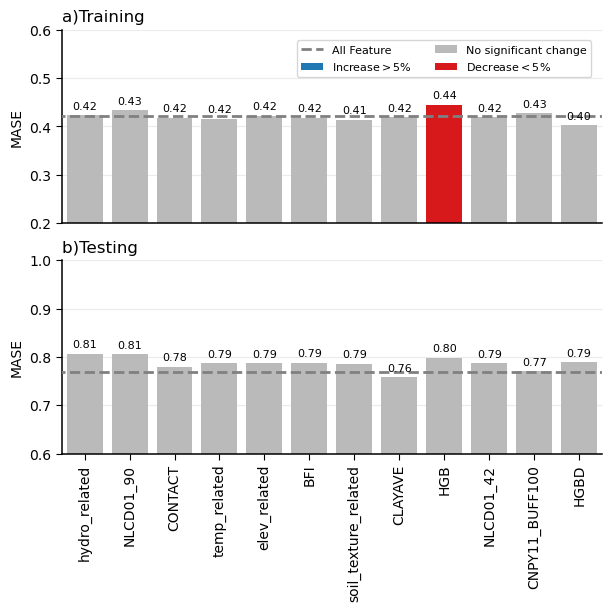

In [30]:
std = 0.420420964803733
below_average = plot_data[plot_data['train']<= 0.95*std]
nc = plot_data[(plot_data['train']> 0.95*std) & (plot_data['train']< 1.05*std)]
above_average = plot_data[plot_data['train']>= 1.05*std]
colors_high = ["#d7191c", "#d7191c"] # Extreme colours of the high scale
colors_nochange = ['#bababa', '#bababa']
colors_low = ["#2c7bb6","#2c7bb6"] # Extreme colours of the low scale

cmap_low = mpl.colors.LinearSegmentedColormap.from_list("low_map", colors_low, N=256)
cmap_nochange = mpl.colors.LinearSegmentedColormap.from_list("low_map", colors_nochange, N=256)
cmap_high = mpl.colors.LinearSegmentedColormap.from_list("high_map", colors_high, N=256)

norm_low = mpl.colors.Normalize(below_average['train'].min(), 0.95*std) # linearly normalizes data into the [0.0, 1.0] interval
norm_nochange = mpl.colors.Normalize(0.95*std, 1.05*std)
norm_high = mpl.colors.Normalize(1.05*std, above_average['train'].max())

fig = plt.figure(figsize=(6,6), constrained_layout=True)
fig.patch.set_facecolor('white')
plt.rcParams['font.size'] = 10
spec = fig.add_gridspec(2, 1)

ax0 = fig.add_subplot(spec[0, 0])
ax0.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

bar1 = ax0.bar(below_average['label'], below_average['train'], color=cmap_low(norm_low(below_average['train'])), width=0.8, label='Increase$> 5\%$', zorder=2)
barnc = ax0.bar(nc['label'], nc['train'], color=cmap_nochange(norm_nochange(nc['train'])), width=0.8, label='No significant change', zorder=2)
bar2 = ax0.bar(above_average['label'], above_average['train'], color=cmap_high(norm_high(above_average['train'])), width=0.8, label='Decrease$< 5\%$', zorder=2)
ax0.bar_label(bar1, labels=[f'{e:,.2f}' for e in below_average['train']], padding=3, color='black', fontsize=8, zorder = 4) 
ax0.bar_label(barnc, labels=[f'{e:,.2f}' for e in nc['train']], padding=3, color='black', fontsize=8, zorder = 4) 
ax0.bar_label(bar2, labels=[f'{e:,.2f}' for e in above_average['train']], padding=3, color='black', fontsize=8, zorder = 4) 
ax0.hlines(y = std , xmin=-1, xmax=12, linewidth=2, linestyle = '--', color = 'grey', label = 'All Feature' ,zorder = 3)

ax0.set_ylabel('MASE')
ax0.set_ylim((0.2, 0.6))
ax0.set_xlim((-0.5,11.5))
ax0.set_xticks([])
ax0.set_title('a)Training', loc = 'left')
ax0.spines[['top','right']].set_visible(False)
ax0.spines['left'].set_linewidth(1.1)
ax0.spines['bottom'].set_linewidth(1.1)
ax0.tick_params(axis='x', which='both', length = 4, bottom=True, top=False, labelbottom=True)
ax0.tick_params(axis='y', which='both', length = 4, left=True, right=False, labelleft=True)
ax0.legend(loc=7, bbox_to_anchor=(0.98, 0.85), ncol=2, borderaxespad=0, frameon=True, fontsize=8)


std_1 = 0.768564600388366
below_average_1 = plot_data[plot_data['test']<=0.95*std_1]
nc_1 = plot_data[(plot_data['test']>0.95*std_1) & (plot_data['test']<1.05*std_1)]
above_average_1 = plot_data[plot_data['test']>=1.05*std_1]
norm_low_1 = mpl.colors.Normalize(below_average_1['test'].min(), 0.95*std_1) # linearly normalizes data into the [0.0, 1.0] 
norm_nc_1 = mpl.colors.Normalize(0.95*std_1, 1.05*std_1)
norm_high_1 = mpl.colors.Normalize(1.05*std_1, above_average_1['test'].max())


ax1 = fig.add_subplot(spec[1, 0])
ax1.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)
bar3 = ax1.bar(below_average_1['label'], below_average_1['test'], color=cmap_low(norm_low_1(below_average_1['test'])), width=0.8, zorder=2)
barnc_1 = ax1.bar(nc_1['label'], nc_1['test'], color=cmap_nochange(norm_nc_1(nc_1['test'])), width=0.8, zorder=2)
bar4 = ax1.bar(above_average_1['label'], above_average_1['test'], color=cmap_high(norm_high_1(above_average_1['test'])), width=0.8, zorder=2)
ax1.bar_label(bar3, labels=[f'{e:,.2f}' for e in below_average_1['test']], padding=3, color='black', fontsize=8, zorder = 4) 
ax1.bar_label(barnc_1, labels=[f'{e:,.2f}' for e in nc_1['test']], padding=3, color='black', fontsize=8, zorder = 4) 
ax1.bar_label(bar4, labels=[f'{e:,.2f}' for e in above_average_1['test']], padding=3, color='black', fontsize=8, zorder = 4) 
ax1.hlines(y = std_1 , xmin=-1, xmax=12, linewidth=2, linestyle = '--', color = 'grey', label = 'All Feature' ,zorder = 3)

ax1.set_xticks(y_pos)
ax1.set_xticklabels(objective, rotation=90)
ax1.set_ylabel('MASE')
ax1.set_ylim((0.6,1))
ax1.set_xlim((-0.5,11.5))
ax1.set_title('b)Testing ', loc = 'left')
ax1.spines[['top','right']].set_visible(False)
ax1.spines['left'].set_linewidth(1.1)
ax1.spines['bottom'].set_linewidth(1.1)
ax1.tick_params(axis='x', which='major', length = 4, bottom=True, top=False, labelbottom=True)
ax1.tick_params(axis='y', which='major', length = 4, left=True, right=False, labelleft=True)
fig.savefig(os.path.join(Path_Plot,'model_sensitivity.png'), dpi = 300)

In [ ]:
# Constants
STD_TRAIN = 0.420420964803733
STD_TEST = 0.768564600388366
COLOR_HIGH = ["#d7191c", "#d7191c"]
COLOR_NOCHANGE = ['#bababa', '#bababa']
COLOR_LOW = ["#2c7bb6", "#2c7bb6"]

# Create color maps
cmap_low = mpl.colors.LinearSegmentedColormap.from_list("low_map", COLOR_LOW, N=256)
cmap_nochange = mpl.colors.LinearSegmentedColormap.from_list("nochange_map", COLOR_NOCHANGE, N=256)
cmap_high = mpl.colors.LinearSegmentedColormap.from_list("high_map", COLOR_HIGH, N=256)

fig = plt.figure(figsize=(6, 6), constrained_layout=True)
fig.patch.set_facecolor('white')
plt.rcParams['font.size'] = 10
spec = fig.add_gridspec(2, 1)

# Plot training data
ax0 = fig.add_subplot(spec[0, 0])
below_average = plot_data[plot_data['train'] <= 0.95 * STD_TRAIN]
no_change = plot_data[(plot_data['train'] > 0.95 * STD_TRAIN) & (plot_data['train'] < 1.05 * STD_TRAIN)]
above_average = plot_data[plot_data['train'] >= 1.05 * STD_TRAIN]

norm_low = mpl.colors.Normalize(below_average['train'].min(), 0.95 * STD_TRAIN)
norm_nochange = mpl.colors.Normalize(0.95 * STD_TRAIN, 1.05 * STD_TRAIN)
norm_high = mpl.colors.Normalize(1.05 * STD_TRAIN, above_average['train'].max())

ax0.bar(below_average['label'], below_average['train'], color=cmap_low(norm_low(below_average['train'])), width=0.8, zorder=2)
ax0.bar(no_change['label'], no_change['train'], color=cmap_nochange(norm_nochange(no_change['train'])), width=0.8, zorder=2)
ax0.bar(above_average['label'], above_average['train'], color=cmap_high(norm_high(above_average['train'])), width=0.8, zorder=2)

ax0.hlines(y=STD_TRAIN, xmin=-1, xmax=12, linewidth=2, linestyle='--', color='grey', label='All Feature', zorder=3)
ax0.set_title('a) Training', loc='left')
ax0.set_ylabel('MASE')
ax0.set_ylim(0.2, 0.6)
ax0.set_xlim(-0.5, 11.5)
ax0.set_xticks([])
ax0.legend(loc=7, bbox_to_anchor=(0.98, 0.85), ncol=2, borderaxespad=0, frameon=True, fontsize=8)

# Plot testing data
ax1 = fig.add_subplot(spec[1, 0])
below_average = plot_data[plot_data['test'] <= 0.95 * STD_TEST]
no_change = plot_data[(plot_data['test'] > 0.95 * STD_TEST) & (plot_data['test'] < 1.05 * STD_TEST)]
above_average = plot_data[plot_data['test'] >= 1.05 * STD_TEST]

norm_low = mpl.colors.Normalize(below_average['test'].min(), 0.95 * STD_TEST)
norm_nochange = mpl.colors.Normalize(0.95 * STD_TEST, 1.05 * STD_TEST)
norm_high = mpl.colors.Normalize(1.05 * STD_TEST, above_average['test'].max())

ax1.bar(below_average['label'], below_average['test'], color=cmap_low(norm_low(below_average['test'])), width=0.8, zorder=2)
ax1.bar(no_change['label'], no_change['test'], color=cmap_nochange(norm_nochange(no_change['test'])), width=0.8, zorder=2)
ax1.bar(above_average['label'], above_average['test'], color=cmap_high(norm_high(above_average['test'])), width=0.8, zorder=2)

ax1.hlines(y=STD_TEST, xmin=-1, xmax=12, linewidth=2, linestyle='--', color='grey', label='All Feature', zorder=3)
ax1.set_title('b) Testing', loc='left')
ax1.set_ylabel('MASE')
ax1.set_ylim(0.6, 1)
ax1.set_xlim(-0.5, 11.5)
ax1.set_xticks(plot_data['label'])
ax1.set_xticklabels(plot_data['label'], rotation=90)